In [1]:
import os
import random
import pandas as pd
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import sampler
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torch.optim.lr_scheduler import StepLR

C:\Users\herb0\AppData\Local\Temp\ipykernel_16972\294205285.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
USE_GPU = True
num_class = 9
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cuda


In [3]:
def get_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

In [4]:
class TinyLISA(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_dir = img_dir
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform
        self.label_map = {label: index for index, label in enumerate(self.annotations['class'].unique())}
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_info = self.annotations.iloc[idx]
        img_path = os.path.join(self.img_dir, img_info['filename'])
        image = Image.open(img_path).convert('L')

        image = image.convert('RGB')

        box = [img_info['x1'], img_info['y1'], img_info['x2'], img_info['y2']]
        label = self.label_map[img_info['class']]

        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        return image, box, label
    
    def load_image(self, idx):
        img_info = self.annotations.iloc[idx]
        img_path = os.path.join(self.img_dir, img_info['filename'])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = np.stack([image, image, image], axis=-1)
        return image, img_info
    
    def get_batch(self, batch_size):
        unique_labels = set() 
        batch_images = []
        batch_annotations = []
        
        while len(unique_labels) < 9:
            all_indices = list(range(len(self.annotations)))
            selected_index = random.choice(all_indices) 
            img_info = self.annotations.iloc[selected_index]
            label = self.label_map[img_info['class']]
            
            if label not in unique_labels:
                unique_labels.add(label)
                image, annotation = self.load_image(selected_index)
                batch_images.append(image)
                batch_annotations.append(annotation)

        return batch_images, batch_annotations

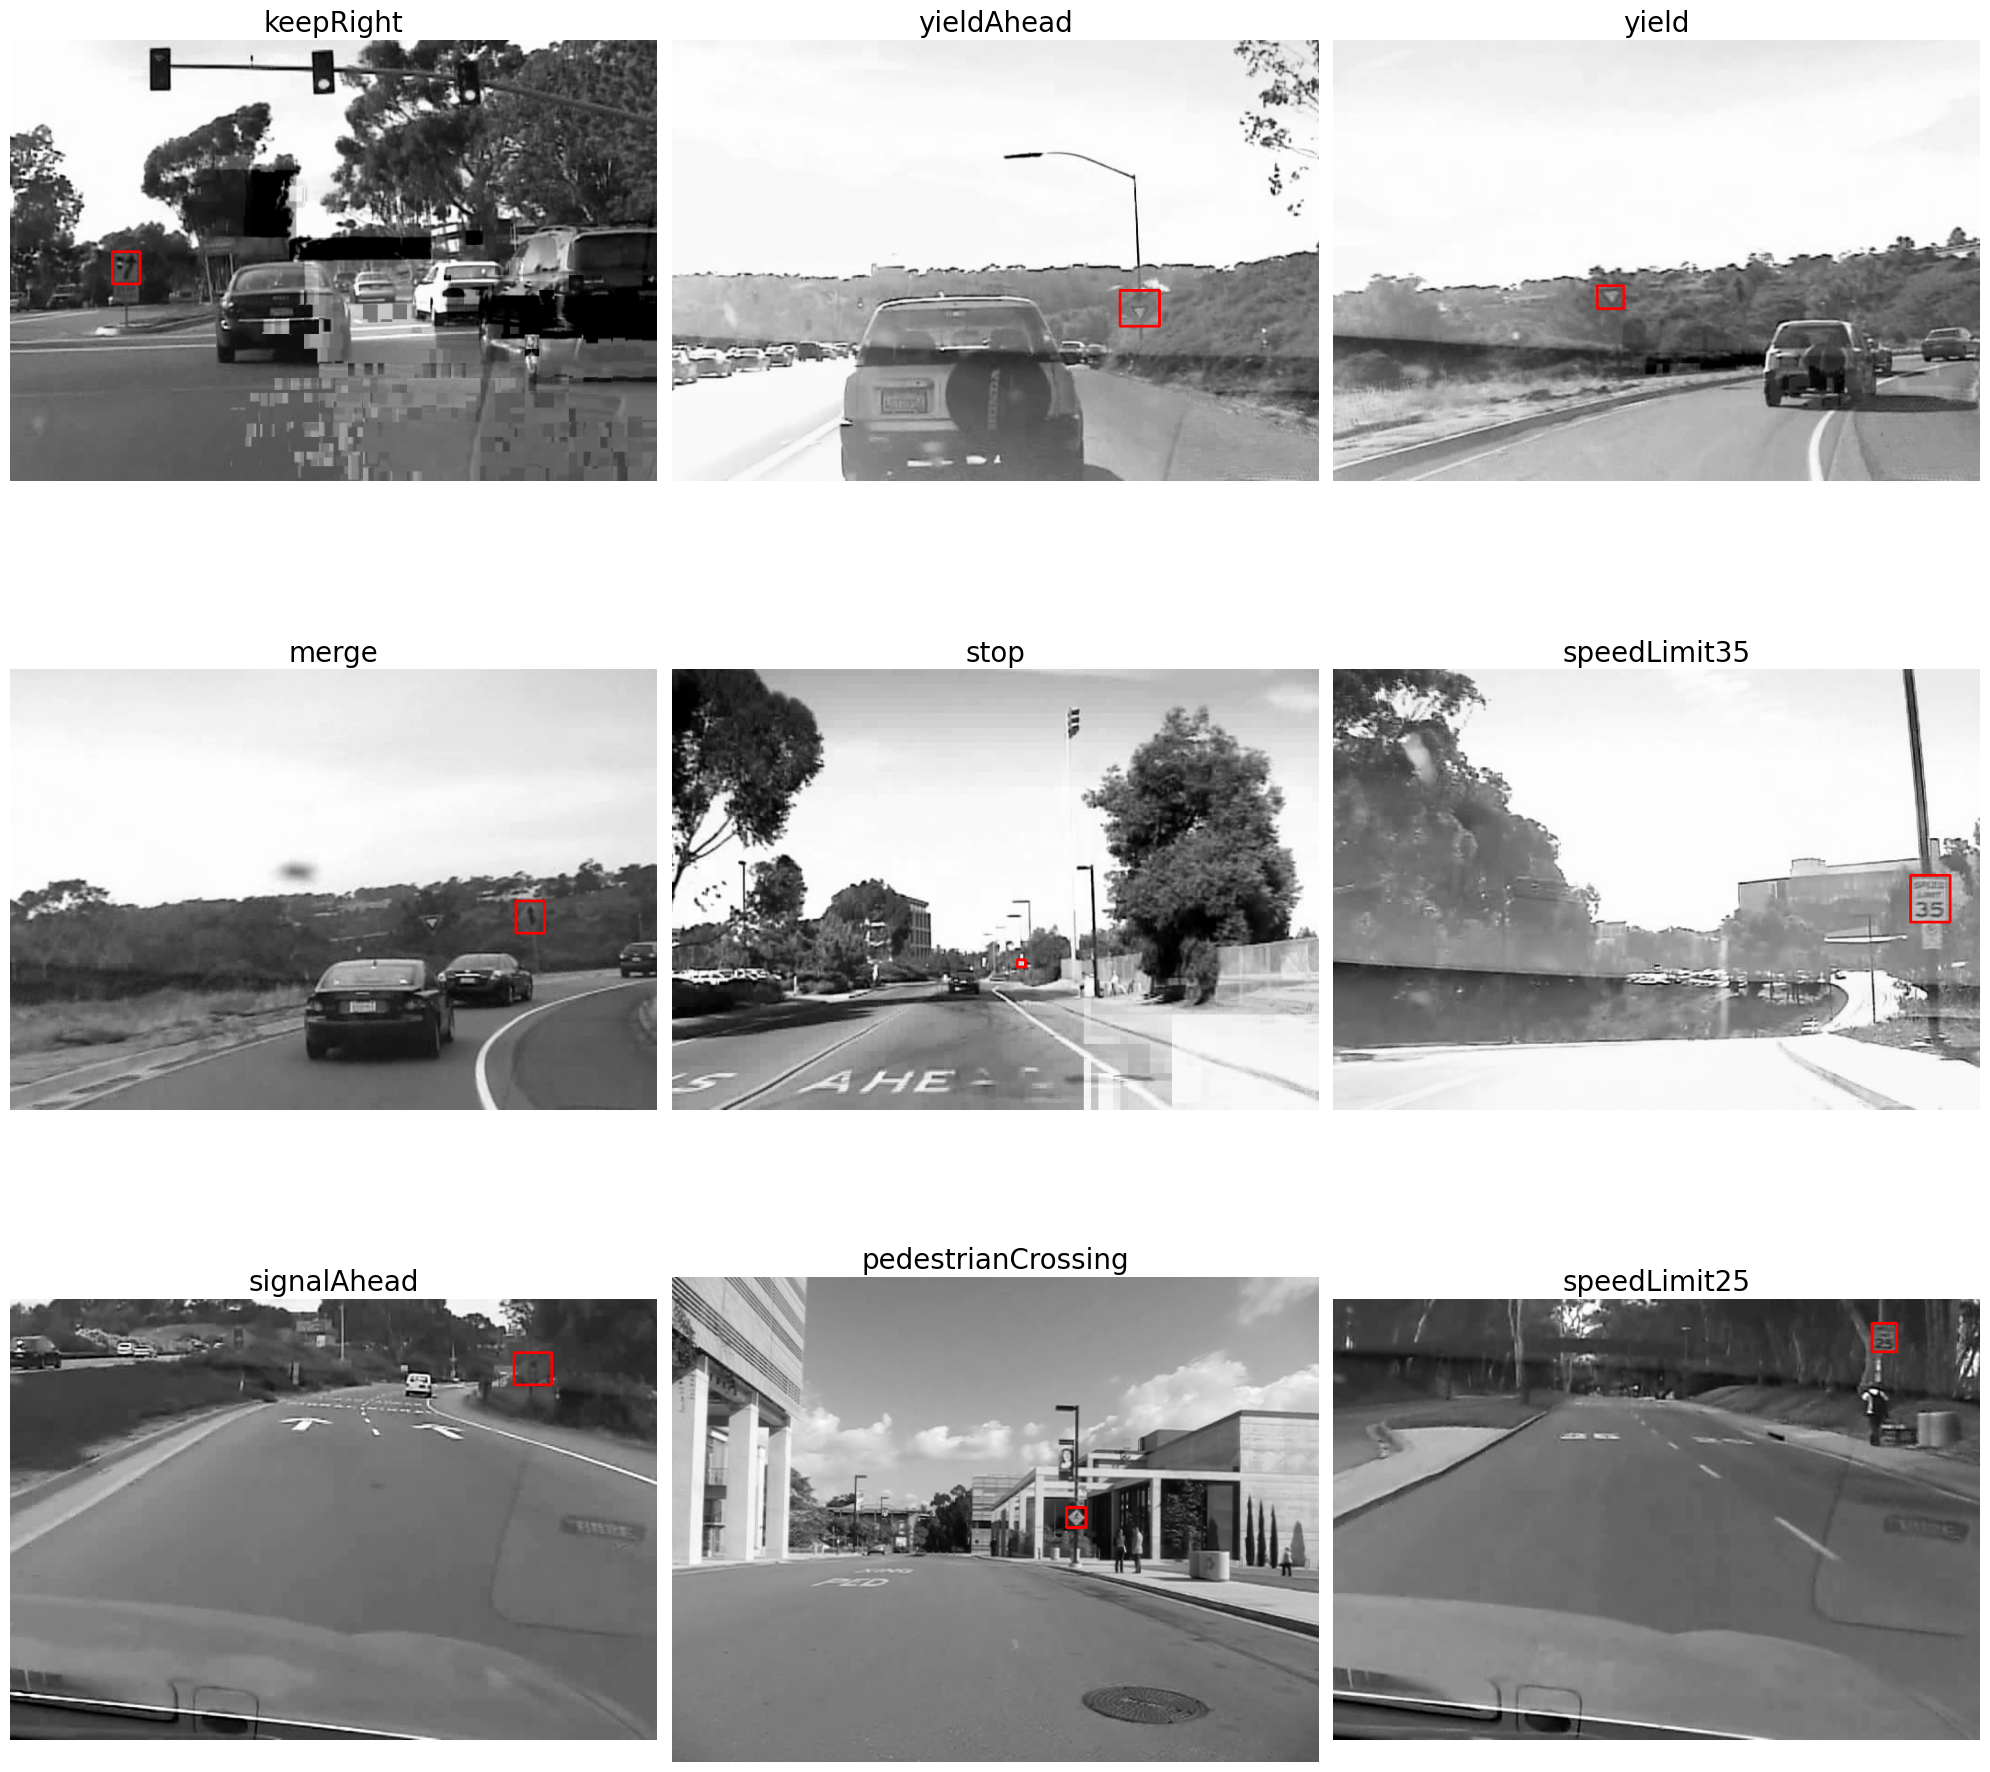

In [5]:
img_dir = 'datasets/db_lisa_tiny/'
annotations_file = img_dir + 'annotations.csv'
tiny_lisa = TinyLISA(img_dir, annotations_file, transform=get_transform())
batch_images, batch_annotations = tiny_lisa.get_batch(9)
plt.figure(figsize=(20, 20))

for i, (image, annotation) in enumerate(zip(batch_images, batch_annotations)):
    plt.subplot(3, 3, i+1)  
    cv2.rectangle(image, (annotation['x1'], annotation['y1']), (annotation['x2'], annotation['y2']), (255, 0, 0), 2)
    plt.imshow(image)
    plt.title(annotation['class'], fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
class LISA(Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        columns_to_load = ['Filename', 'Upper left corner X', 'Upper left corner Y',
                           'Lower right corner X', 'Lower right corner Y', 'Annotation tag']
        self.annotations = pd.read_csv(
            os.path.join(root_dir, annotations_file),
            delimiter=';', 
            usecols=lambda column: column.strip() in columns_to_load  
        )
        self.label_map = {label: index for index, label in enumerate(self.annotations['Annotation tag'].unique())}
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_info = self.annotations.iloc[idx]
        img_path = os.path.join(self.root_dir, img_info['Filename'])
        image = Image.open(img_path).convert('L')
        
        image = image.convert('RGB') 

        box = [img_info['Upper left corner X'], img_info['Upper left corner Y'],
               img_info['Lower right corner X'], img_info['Lower right corner Y']]
        
        label = self.label_map[img_info['Annotation tag']]
        label_tensor = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)


        return image, box, label_tensor

    def load_image(self, idx):
        img_info = self.annotations.iloc[idx]
        img_path = os.path.join(self.root_dir, img_info['Filename'])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = np.stack([image] * 3, axis=-1)  # Stack image to 3 channels
        return image, img_info['Annotation tag']
    
    def get_batch(self, batch_size):
        unique_labels = set()
        batch_images = []
        batch_annotations = []
        
        while len(unique_labels) < batch_size:
            selected_index = random.choice(range(len(self.annotations)))
            img_info = self.annotations.iloc[selected_index]
            label = self.label_map[img_info['Annotation tag']]
            
            if label not in unique_labels:
                unique_labels.add(label)
                image, class_label = self.load_image(selected_index)
                batch_images.append(image)
                box = [img_info['Upper left corner X'], img_info['Upper left corner Y'],
                       img_info['Lower right corner X'], img_info['Lower right corner Y']]
                batch_annotations.append((box, class_label))

        return batch_images, batch_annotations


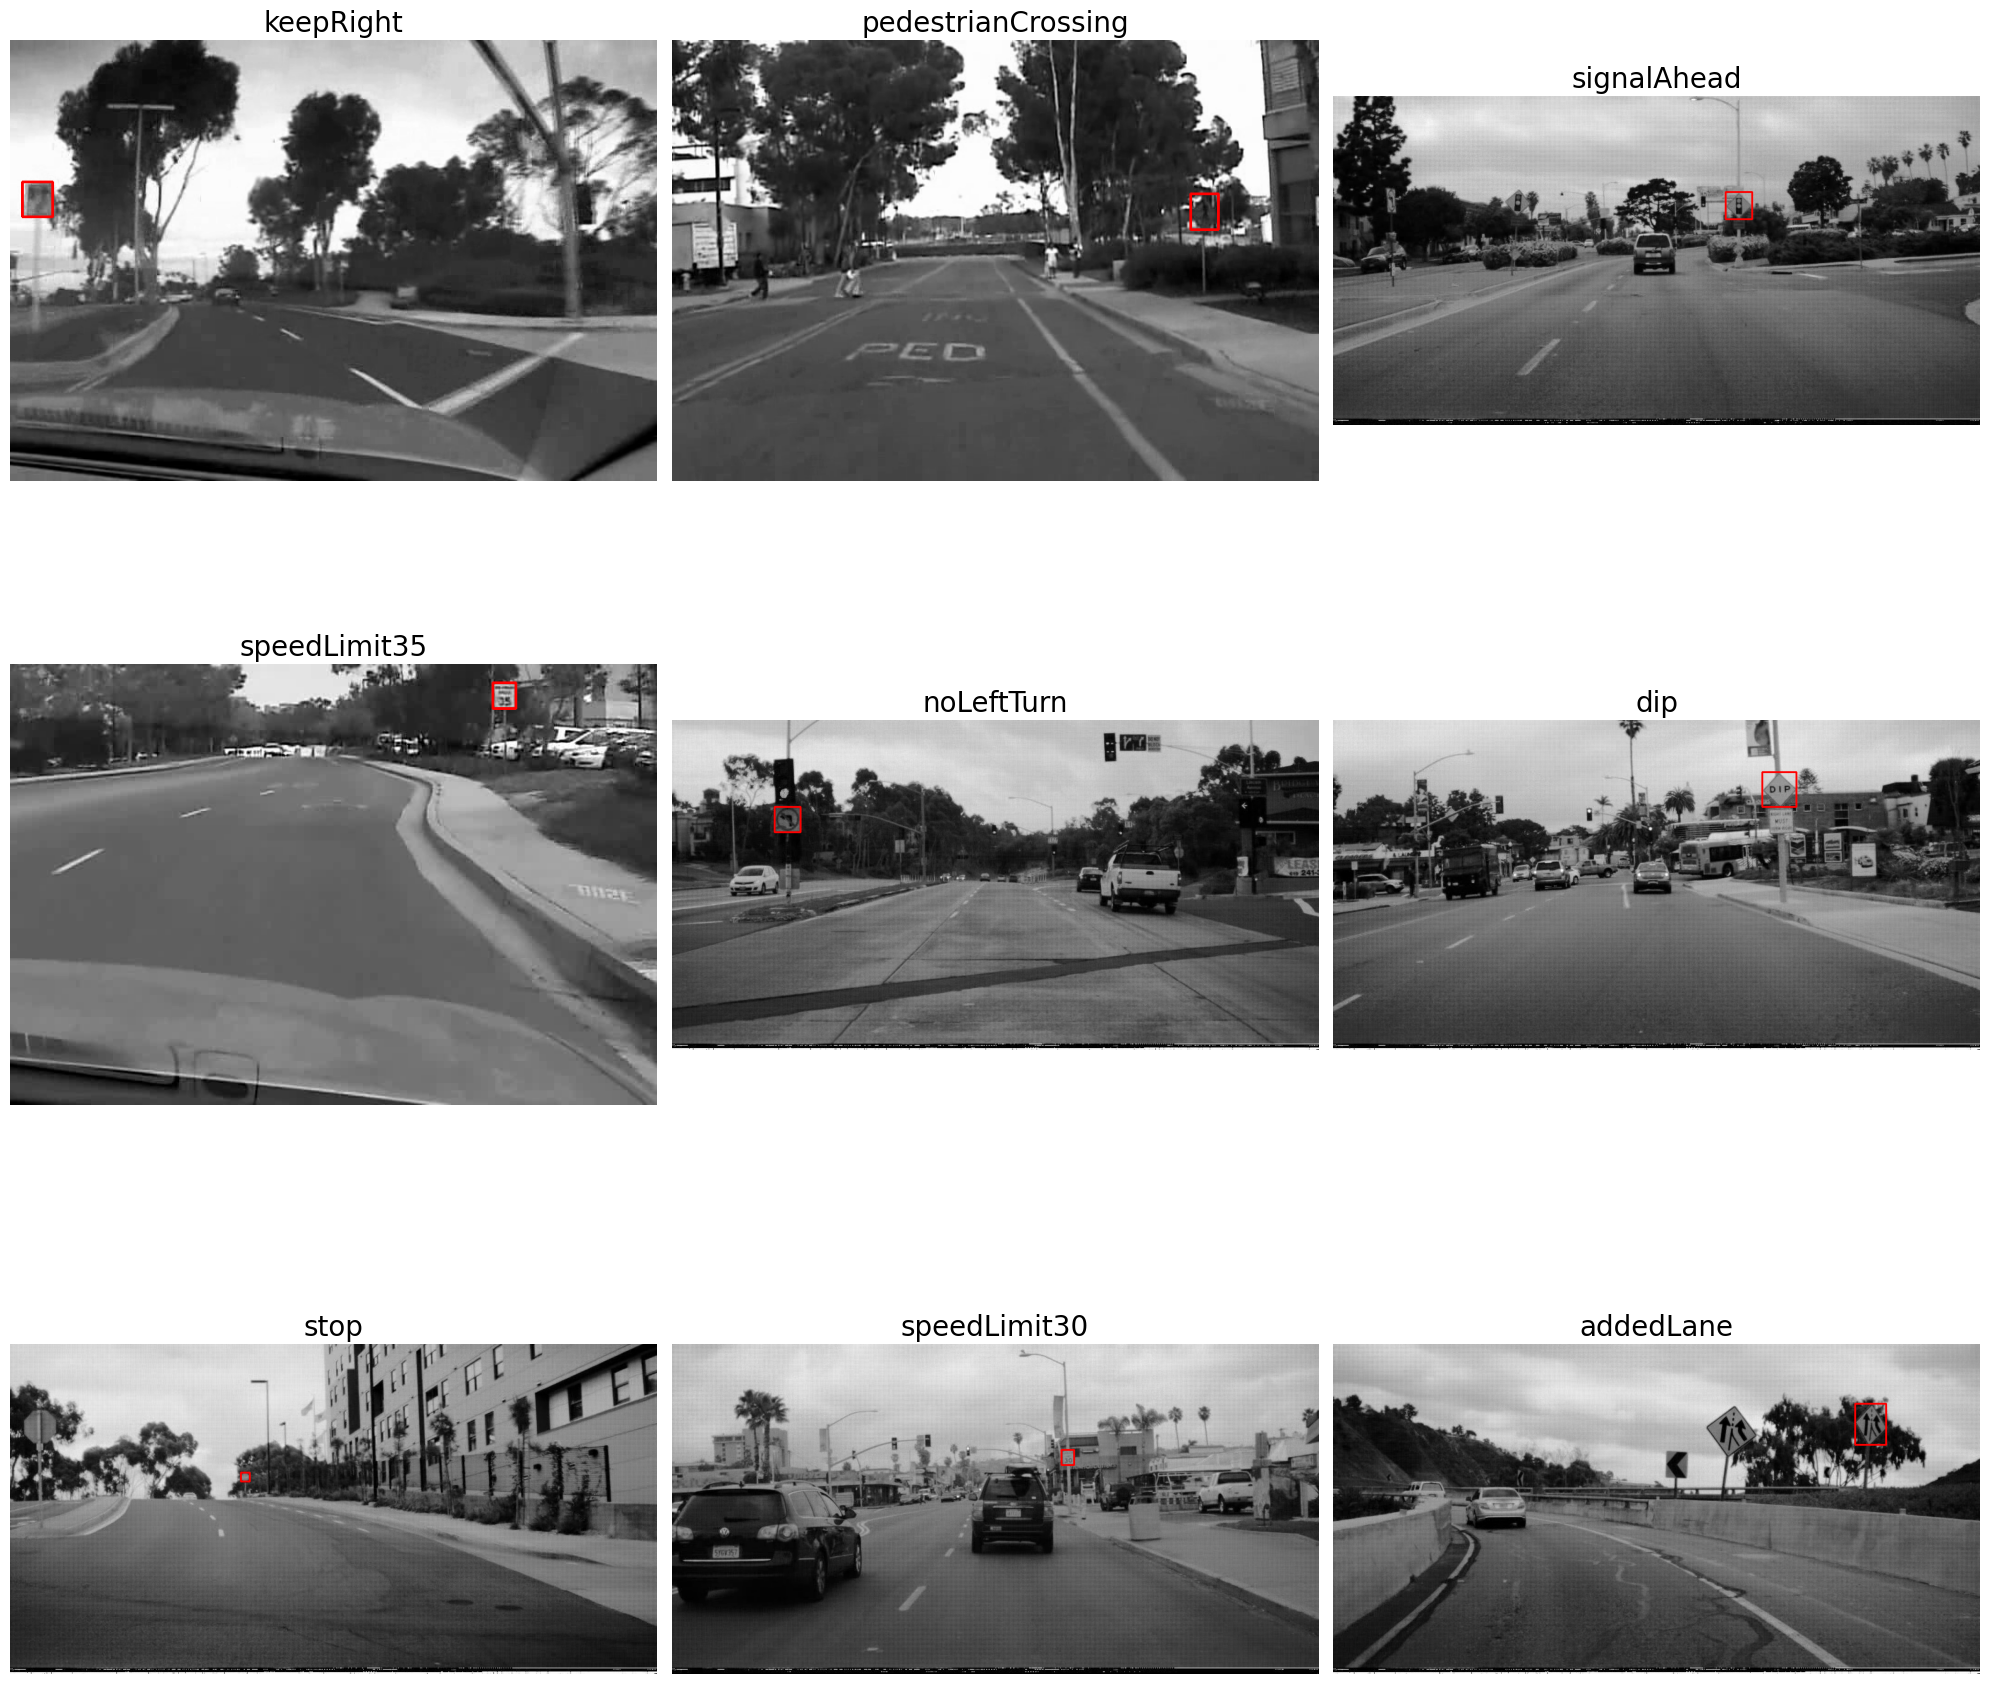

In [7]:
root_dir = 'Datasets/signDatabasePublicFramesOnly/'
annotations_file = 'allAnnotations.csv'
lisa_dataset = LISA(root_dir, annotations_file, transform=get_transform())
batch_images, batch_annotations = lisa_dataset.get_batch(9)
plt.figure(figsize=(20, 20))

for i, (image_np, annotation) in enumerate(zip(batch_images, batch_annotations)):
    box, label = annotation
    plt.subplot(3, 3, i+1) 

    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    plt.imshow(image_np)
    plt.title(label, fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
def check_accuracy_part34(loader, model, set_name="Validation"):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, _, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
    return acc

def train_part34(model, optimizer, loader_train, loader_val, print_every, scheduler=None, epochs=1):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.float32
    model = model.to(device=device)
    loss_history = []
    accuracy_history = []

    for e in range(epochs):
        model.train()
        for t, (x, _, y) in enumerate(loader_train):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (t + 1) % print_every == 0:
                loss_history.append(loss.item())

        val_acc = check_accuracy_part34(loader_val, model)
        accuracy_history.append(val_acc)

        if scheduler is not None:
            scheduler.step()

    return loss_history, accuracy_history

def plot_metrics(model1_metrics, model2_metrics):
    model1_loss, model1_accuracy = model1_metrics
    model2_loss, model2_accuracy = model2_metrics

    epochs_range = range(1, len(model1_loss) + 1)

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, model1_loss, label='Model 1 Loss')
    plt.plot(epochs_range, model2_loss, label='Model 2 Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs_range)  
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, model1_accuracy, label='Model 1 Accuracy')
    plt.plot(epochs_range, model2_accuracy, label='Model 2 Accuracy')
    plt.title('Validation Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs_range)  
    plt.legend()

    plt.tight_layout()
    plt.show()


def flatten(x):
    return x.view(x.size(0), -1)

In [9]:
class ResidualBlock_Batch_X(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding=1, stride=1, width=4, groups=32):
        super(ResidualBlock_Batch_X, self).__init__()
        group_channels = groups * width
        ## First Filter
        self.conv1 = nn.Conv2d(in_channel, group_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.LeakyReLU(0.1)
        
        ## Second Filter
        self.conv2 = nn.Conv2d(group_channels, group_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        
        ## Third Filter
        self.conv3 = nn.Conv2d(group_channels, out_channel, kernel_size=1, stride=1, padding=0)
        
        
        self.batch_norm_group = nn.BatchNorm2d(group_channels)
        self.batch_norm_final = nn.BatchNorm2d(out_channel)

        self.downsample = None
        if in_channel != out_channel or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channel),
            )

    def forward(self, x):
        residual = x

        ## First 
        out = self.relu(self.conv1(x))
        
        ## Second
        out = self.relu(self.batch_norm_group(self.conv2(out)))

        ## Third
        out = self.batch_norm_final(self.conv3(out))
        
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet_Batch_X(nn.Module):
    def __init__(self, num_classes):
        super(ResNet_Batch_X, self).__init__()
        ## First Convolutional Layer
        self.channel_count = 64
        self.conv1 = nn.Conv2d(3, self.channel_count, kernel_size = 7, padding = 3, stride=2)
        self.batch_norm = nn.BatchNorm2d(self.channel_count)
        
        ## Second Convolutional Layer
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding = 1)
        self.conv2 = ResidualBlock_Batch_X(self.channel_count, self.channel_count, kernel_size = 3, groups=32)
        ## Third Convolutional Layer
        self.conv3 = ResidualBlock_Batch_X(self.channel_count, self.channel_count * 2, kernel_size = 3, groups=32)
        ## Fourth Convolutional Layer
        self.conv4 = ResidualBlock_Batch_X(self.channel_count * 2, self.channel_count * 4, kernel_size = 3, groups=32)
        ## Fifth Convolutional Layer
        self.conv5 = ResidualBlock_Batch_X(self.channel_count * 4, self.channel_count * 8, kernel_size = 3, groups =32)
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.channel_count * 8, num_classes)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        ## First Layer
        x = self.relu(self.batch_norm(self.conv1(x)))
        
        ## Second Layer
        x = self.conv2(self.max_pool(x))
        
        ## Third Layer
        x = self.conv3(x)
        
        ## Fourth layer
        x = self.conv4(x)
        
        ## Fifth Layer
        x = self.avg_pool(self.conv5(x))
        x = flatten(x)
        
        scores = self.fc(x)
        return scores

In [10]:
train_size = int(0.5 * len(tiny_lisa))
val_size = int(0.5 * train_size)
test_size = val_size

tiny_train_dataset, tiny_val_dataset, tiny_test_dataset = random_split(tiny_lisa, [train_size, val_size, test_size])

loader_train_tiny  = DataLoader(tiny_train_dataset, batch_size=8, num_workers=0, sampler=sampler.SubsetRandomSampler(range(0, train_size)))
loader_val_tiny = DataLoader(tiny_val_dataset, batch_size=8, num_workers=0)
loader_test_tiny = DataLoader(tiny_test_dataset, batch_size=8, num_workers=0)

In [12]:
learning_rate = 1e-3
device = torch.device("cuda")
model = ResNet_Batch_X(num_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print_every = 56
tiny_lisa_loss, tiny_lisa_accuracy = train_part34(model, optimizer, loader_train_tiny, loader_val_tiny, print_every, scheduler, epochs=20)

In [13]:
model.eval()
test_acc = check_accuracy_part34(loader_test_tiny, model) * 100
print(f"Test accuracy: {test_acc:.2f}%")


Test accuracy: 73.33%


In [14]:
class CombinedLISADataset(Dataset):
    def __init__(self, tiny_dataset, lisa_root_dir, lisa_annotations_file, transform=None):
        self.lisa_root_dir = lisa_root_dir
        self.tiny_dataset = tiny_dataset
        self.transform = transform
        self.label_map = tiny_dataset.label_map
        

        self.lisa_annotations = pd.read_csv(os.path.join(lisa_root_dir, lisa_annotations_file), delimiter=';')
        self.lisa_annotations = self.lisa_annotations[self.lisa_annotations['Annotation tag'].isin(self.label_map.keys())]

    def __len__(self):
        return len(self.tiny_dataset) + len(self.lisa_annotations)

    def __getitem__(self, idx):
        if idx < len(self.tiny_dataset):
            return self.tiny_dataset[idx]
        else:
            lisa_idx = idx - len(self.tiny_dataset)
            row = self.lisa_annotations.iloc[lisa_idx]
            
            image_path = os.path.join(self.lisa_root_dir, row['Filename'])
            image = Image.open(image_path).convert('RGB')
            box = [row['Upper left corner X'], row['Upper left corner Y'], row['Lower right corner X'], row['Lower right corner Y']]
            label = self.label_map[row['Annotation tag']]

            if self.transform:
                image = self.transform(image)
            
            return image, box, torch.tensor(label, dtype=torch.long)

tiny_dataset = TinyLISA(img_dir='datasets/db_lisa_tiny/', annotations_file='datasets/db_lisa_tiny/annotations.csv', transform=get_transform())
lisa_dataset = CombinedLISADataset(tiny_dataset=tiny_dataset, lisa_root_dir='datasets/signDatabasePublicFramesOnly/', lisa_annotations_file='allAnnotations.csv', transform=get_transform())

In [15]:
total_size = len(lisa_dataset)
train_size = int(total_size * 0.4) 
val_size = int(total_size * 0.3)   
test_size = total_size - train_size - val_size  
combined_train_dataset, combined_val_dataset, combined_test_dataset = torch.utils.data.random_split(lisa_dataset, [train_size, val_size, test_size])

batch_size = 32
loader_train_combined = DataLoader(combined_train_dataset, batch_size, num_workers=0, sampler=sampler.SubsetRandomSampler(range(0, train_size)))
loader_val_combined = DataLoader(combined_val_dataset, batch_size, num_workers=0)
loader_test_combined = DataLoader(combined_test_dataset, batch_size, num_workers=0)

In [16]:
print_every = int(len(combined_train_dataset) / batch_size)
learning_rate = 1e-3
model = ResNet_Batch_X(num_class)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
combined_loss, combined_accuracy = train_part34(model, optimizer, loader_train_combined, loader_val_combined, print_every, scheduler, epochs=20)

In [17]:
model.eval()
test_acc = check_accuracy_part34(loader_test_combined, model) * 100
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 84.43%


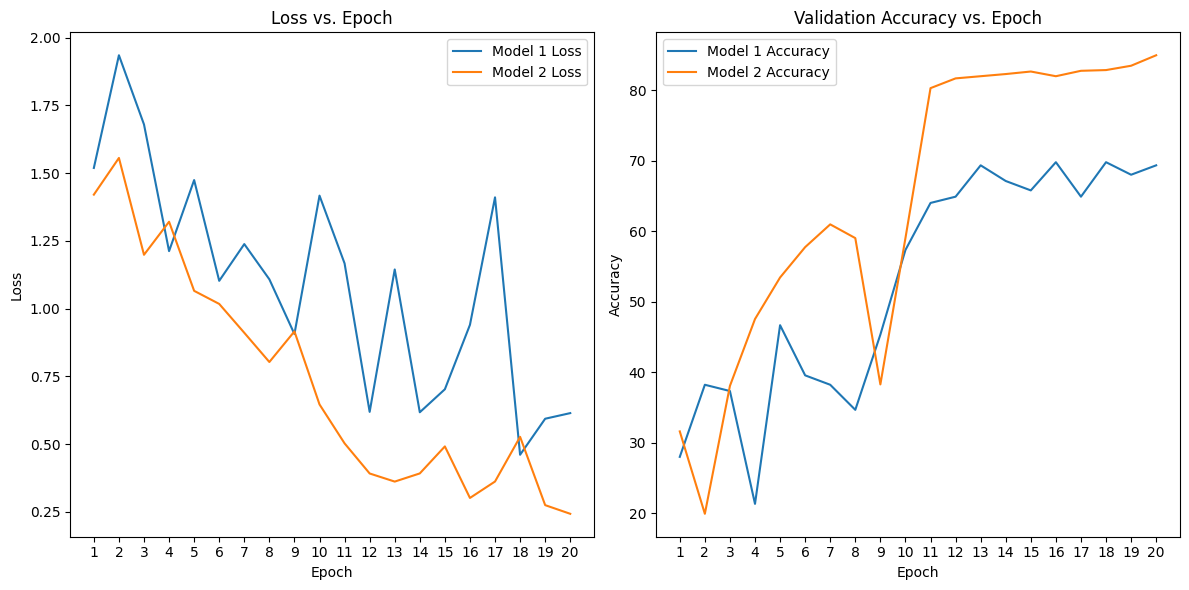

In [18]:
tiny_lisa_accuracy = [acc * 100 for acc in tiny_lisa_accuracy]
combined_accuracy = [acc * 100 for acc in combined_accuracy]
plot_metrics([tiny_lisa_loss, tiny_lisa_accuracy], [combined_loss, combined_accuracy])